#### CIE-Project B || Group - 7

#### Imports

In [1]:
import os
import pandas as pd
import numpy as np
import scipy as sp
from scipy.signal import resample, find_peaks
from scipy.io import loadmat
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import pickle
import time

# from sklearn import preprocessing ##importing for normalization
# from sklearn.decomposition import PCA
# from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.preprocessing import MinMaxScaler, minmax_scale, StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv1D, Conv2D, MaxPooling1D, MaxPooling2D, LSTM, CuDNNLSTM
from keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping
from keras.utils import np_utils
from keras_tuner.tuners import RandomSearch
from keras_tuner.engine.hyperparameters import HyperParameters

plt.rcParams['figure.dpi'] = 100
plt.rcParams['axes.grid'] = True
plt.rcParams['legend.frameon'] = True
# plt.rcParams['figure.figsize'] = (8, 8)
%matplotlib widget

##### Get the root directory and change to it

In [2]:
rootdir = os.getcwd()
os.chdir(rootdir)

#### Folder Variables Assignment

In [3]:
# Names of the folders
Training_Folder = 'EPOT_DATA'
Validation_Aug_Folder = 'Validation_augmented_data'
Experiment = 'Experiment'
Ex_Validation = 'Experimental_validation'

counter = 0

#### Parsing

##### Parse training and validation-augmented data

In [4]:
# Initialize lists for training and validation
training_tr = []; training_tr_labels = []

validation_aug = []; validation_aug_labels = [] # validation augmented data

#------------------------------------------------------------------------------

for subdir, dirs, files in os.walk(rootdir):
    
    if Training_Folder.lower() in subdir.lower():
        for file in files:
            if file.endswith('.mat'):
                lbl = [file.split('_')[1], file.split('_')[2][:3]]
                lb = np.asarray(lbl, dtype=float)
                # load mat-file
                mat = loadmat(os.path.join(subdir, file))
                # get the numpy data from the mat file
                mat = mat['num_data']
                # append data to the list
                training_tr.append(mat)
                training_tr_labels.append(lb)

    elif Validation_Aug_Folder.lower() in subdir.lower():
        for file in files:
            if file.endswith('.mat'):
                lbl = [file.split('_')[1], file.split('_')[2][:3]]
                lb = np.asarray(lbl, dtype=float)
                # load mat-file
                mat = loadmat(os.path.join(subdir, file))
                # get the numpy data from the mat file
                mat = mat['num_data']
                # append data to the list
                validation_aug.append(mat)
                validation_aug_labels.append(lb)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
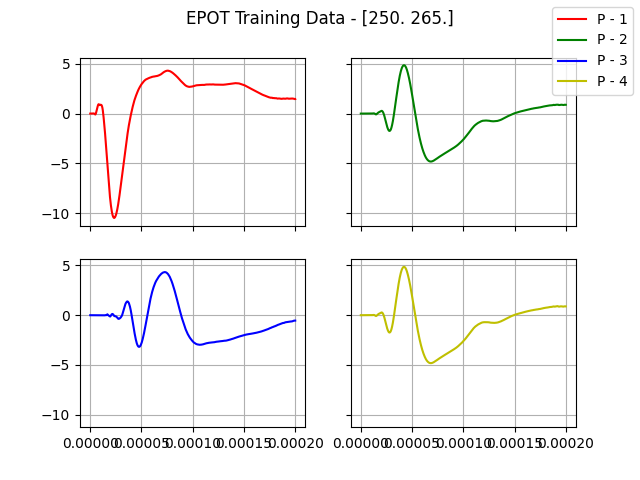

In [5]:
plt.close()
fig, axs = plt.subplots(2, 2, sharex=True, sharey=True)

l = 3

fig.suptitle(f'EPOT Training Data - {training_tr_labels[l]}')

axs[0,0].plot(training_tr[l][:,0], training_tr[l][:,1], label='P - 1', c = 'r')
axs[0,1].plot(training_tr[l][:,0], training_tr[l][:,2], label='P - 2', c = 'g')
axs[1,0].plot(training_tr[l][:,0], training_tr[l][:,3], label='P - 3', c = 'b')
axs[1,1].plot(training_tr[l][:,0], training_tr[l][:,4], label='P - 4', c = 'y')

fig.legend()
plt.show()

##### Parse and cut the experimental data

In [6]:
# Initialize lists for training and validation
ex_data = []; ex_labels = []

#------------------------------------------------------------------------------

for subdir, dirs, files in os.walk(rootdir):
    
    if Experiment.lower() in subdir.lower():
        for file in files:
            if file.endswith('.txt'):
                
                with open(os.path.join(subdir, file), 'r') as f:
                    x = pd.read_csv(os.path.join(subdir, file), delimiter='\t', decimal=',', skiprows=8, header=None)
                    x = np.asarray(x, dtype=float)
                    ex_data.append(x)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
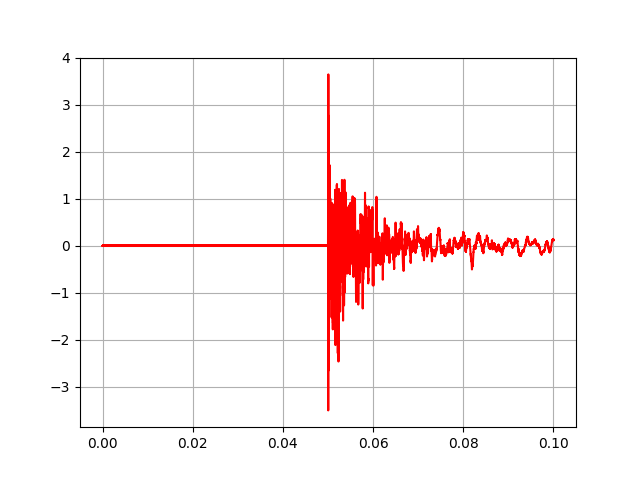

In [36]:
plt.close()
l = 5
plt.plot(ex_data[l][:,0], ex_data[l][:,1], label='P - 1', c = 'r')
plt.show()

In [8]:
ex_cut_data=[]
for i in range(0,len(ex_data)):
    data=ex_data[i][:,0]
    start=np.where(data==0.05)
    end=np.where(data==0.0502)
    d_0=ex_data[i][start[0][0]:end[0][0],0]
    d_1=ex_data[i][start[0][0]:end[0][0],1]
    d_2=ex_data[i][start[0][0]:end[0][0],2]
    d_3=ex_data[i][start[0][0]:end[0][0],3]
    d_4=ex_data[i][start[0][0]:end[0][0],4]

    # append data to a numpy array
    ex_cut_data.append(np.asarray([d_0,d_1,d_2,d_4,d_3]))

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
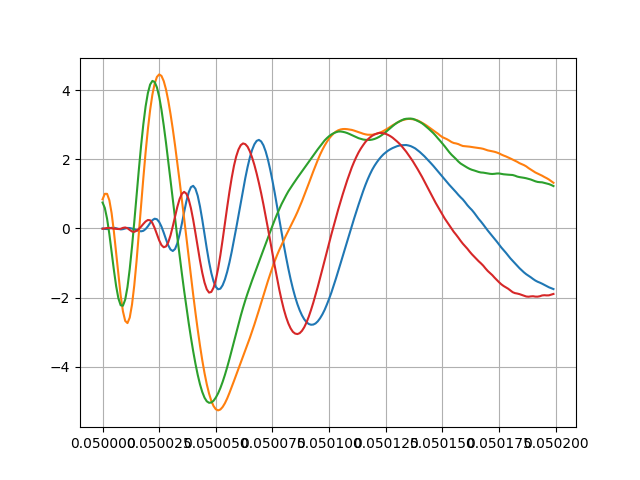

In [37]:
plt.close()
l = 1
plt.plot(ex_cut_data[l][0], ex_cut_data[l][1], label='P - 1')
plt.plot(ex_cut_data[l][0], ex_cut_data[l][2], label='P - 2')
plt.plot(ex_cut_data[l][0], ex_cut_data[l][3], label='P - 3')
plt.plot(ex_cut_data[l][0], ex_cut_data[l][4], label='P - 4')
plt.show()

##### Parse and Cut the experimental validation data

In [10]:
# Initialize lists for training and validation
ex_val_data = []; ex_val_labels = []

#------------------------------------------------------------------------------

for subdir, dirs, files in os.walk(rootdir):
    
    if Ex_Validation.lower() in subdir.lower():
        for file in files:
            if file.endswith('.txt'):
                
                with open(os.path.join(subdir, file), 'r') as f:
                    # print(file.split('_')[2], file.split('_')[3], file.split('_')[5][:3])
                    lbl = [file.split('_')[2], file.split('_')[3], file.split('_')[5][:3]]
                    lb = np.asarray(lbl, dtype=float)

                    x = pd.read_csv(os.path.join(subdir, file), delimiter='\t', decimal=',', skiprows=8, header=None)
                    x = np.asarray(x, dtype=float)
                    ex_val_data.append(x)
                    ex_val_labels.append(lb)

In [33]:
ex_val_cut_data=[]
for i in range(0,len(ex_val_data)):
    data=ex_data[i][:,0]
    start=np.where(data==0.05)
    end=np.where(data==0.0502)
    d = np.zeros(((end[0][0]-start[0][0]),5))

    d[:,0]=ex_val_data[i][start[0][0]:end[0][0],0]
    d[:,1]=ex_val_data[i][start[0][0]:end[0][0],1]
    d[:,2]=ex_val_data[i][start[0][0]:end[0][0],2]
    d[:,3]=ex_val_data[i][start[0][0]:end[0][0],3]
    d[:,4]=ex_val_data[i][start[0][0]:end[0][0],4]
    
    ex_val_cut_data.append(d)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
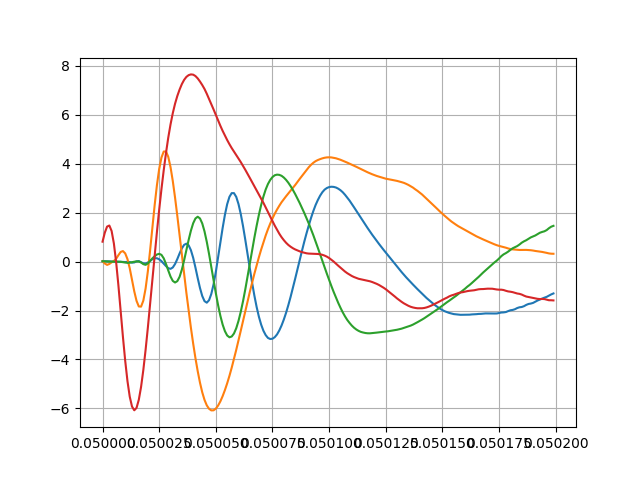

In [34]:
plt.close()
l = 4
plt.plot(ex_val_cut_data[l][:,0], ex_val_cut_data[l][:,1], label='P - 1')
plt.plot(ex_val_cut_data[l][:,0], ex_val_cut_data[l][:,2], label='P - 2')
plt.plot(ex_val_cut_data[l][:,0], ex_val_cut_data[l][:,3], label='P - 3')
plt.plot(ex_val_cut_data[l][:,0], ex_val_cut_data[l][:,4], label='P - 4')
plt.show()

##### Normalize and Resample experimental validation data

In [13]:
# create variables for normalized data
ex_val_norm = np.zeros_like(np.asarray(ex_val_cut_data)); ex_val_norm_labels = np.zeros_like(np.asarray(ex_val_cut_data))

for i in range (0, len(ex_val_cut_data)):
    for j in range (1, 5):
        ex_val_norm[i][:,j] = minmax_scale(ex_val_cut_data[i][:,j])

ex_val_labels = np.delete(ex_val_labels, 2, 1)

scalar = MinMaxScaler()
ex_val_norm_labels = scalar.fit_transform(ex_val_labels)

In [14]:
ex_val_resample = []

# create a dataframe from the normalized data
for i in range (0, len(ex_val_norm)):
    ex_val_resample.append(pd.DataFrame(ex_val_norm[i], columns = ['time', '1', '2', '3', '4']))
    # drop the time column
    ex_val_resample[i] = ex_val_resample[i].drop(columns = ['time'])

size = 100

for i in range (0, len(ex_val_resample)):
    ex_val_resample[i] = resample(ex_val_resample[i], size)

np.asarray(ex_val_resample).shape

(24, 100, 4)

#### Augmentation

##### Variable initialization

In [15]:
## -----------------------------------------------------------------------------
#Assuming P1 on top and counter clockwise order
## -----------------------------------------------------------------------------


# Variables for the augmented data
training_tl = np.zeros_like(np.asarray(training_tr)); training_tl_labels = np.zeros_like(np.asarray(training_tr_labels))
training_bl = np.zeros_like(np.asarray(training_tr)); training_bl_labels = np.zeros_like(np.asarray(training_tr_labels))
training_br = np.zeros_like(np.asarray(training_tr)); training_br_labels = np.zeros_like(np.asarray(training_tr_labels))

##### Top-Left

In [16]:
for i in range (0, len(training_tr)):
        training_tl[i][:,0] = training_tr[i][:,0]
        training_tl[i][:,1] = training_tr[i][:,1]
        training_tl[i][:,2] = training_tr[i][:,4]
        training_tl[i][:,3] = training_tr[i][:,3]
        training_tl[i][:,4] = training_tr[i][:,2]

for i in range (0, len(training_tl_labels)):
    training_tl_labels[i][0] = 500 - training_tr_labels[i][0]
    training_tl_labels[i][1] = training_tr_labels[i][1]

##### Bottom-Left

In [17]:
for i in range (0, len(training_bl)):
    training_bl[i][:,0] = training_tl[i][:,0]
    training_bl[i][:,1] = training_tl[i][:,3]
    training_bl[i][:,2] = training_tl[i][:,2]
    training_bl[i][:,3] = training_tl[i][:,1]
    training_bl[i][:,4] = training_tl[i][:,4]

for i in range (0, len(training_bl_labels)):
    training_bl_labels[i][0] = 500. - training_tr_labels[i][0]
    training_bl_labels[i][1] = 500. - training_tr_labels[i][1]

##### Bottom-Right

In [18]:
for i in range (0, len(training_br)):
        training_br[i][:,0] = training_bl[i][:,0]
        training_br[i][:,1] = training_bl[i][:,1]
        training_br[i][:,2] = training_bl[i][:,4]
        training_br[i][:,3] = training_bl[i][:,3]
        training_br[i][:,4] = training_bl[i][:,2]

for i in range (0, len(training_br_labels)):
    training_br_labels[i][0] = training_tr_labels[i][0]
    training_br_labels[i][1] = 500 - training_tr_labels[i][1]

##### Delete overlapping data points

In [19]:
training_tl = np.delete(np.asarray(training_tl), np.where(np.asanyarray(training_tl_labels) == 250.)[0], axis = 0)
training_tl_labels = np.delete(np.asarray(training_tl_labels), np.where(np.asanyarray(training_tl_labels) == 250.)[0], axis = 0)

training_bl = np.delete(np.asarray(training_bl), 0, axis = 0)
training_bl_labels = np.delete(np.asarray(training_bl_labels), 0, axis = 0)

training_br = np.delete(np.asarray(training_br), np.where(np.asanyarray(training_br_labels) == 250.)[0], axis = 0)
training_br_labels = np.delete(np.asarray(training_br_labels), np.where(np.asanyarray(training_br_labels) == 250.)[0], axis = 0)

##### Makesure the augmentation is done on all quadrants

In [20]:
print(f'{np.asarray(training_tl).shape} \t{np.asarray(training_tr).shape} \n{np.asarray(training_bl).shape} \t{np.asarray(training_br).shape} \n{counter}')

(219, 20000, 5) 	(244, 20000, 5) 
(243, 20000, 5) 	(219, 20000, 5) 
0


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
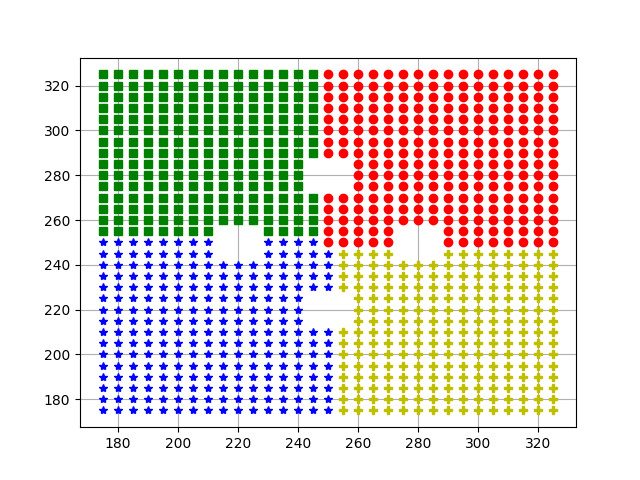

In [21]:
plt.close()
for i in range(0, len(training_tr_labels)):
    plt.plot(training_tr_labels[i][0], training_tr_labels[i][1], 'o', c = 'r')
for j in range (0, len(training_tl_labels)):
    plt.plot(training_tl_labels[j][0], training_tl_labels[j][1], 's', c = 'g')
    plt.plot(training_br_labels[j][0], training_br_labels[j][1], 'P', c = 'y')
for k in range (0, len(training_bl_labels)):
    plt.plot(training_bl_labels[k][0], training_bl_labels[k][1], '*', c = 'b')            

plt.show()

#### Concatenate, Normalize, Resample

##### Concatenate

In [22]:
training = np.concatenate((training_tr, training_tl, training_bl, training_br), axis = 0)
training_labels = np.concatenate((training_tr_labels, training_tl_labels, training_bl_labels, training_br_labels), axis = 0)

print(f'Shape of all training set: {training.shape} \nShape of all training labels: {training_labels.shape}')

Shape of all training set: (925, 20000, 5) 
Shape of all training labels: (925, 2)


##### check with the validation augmented data

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
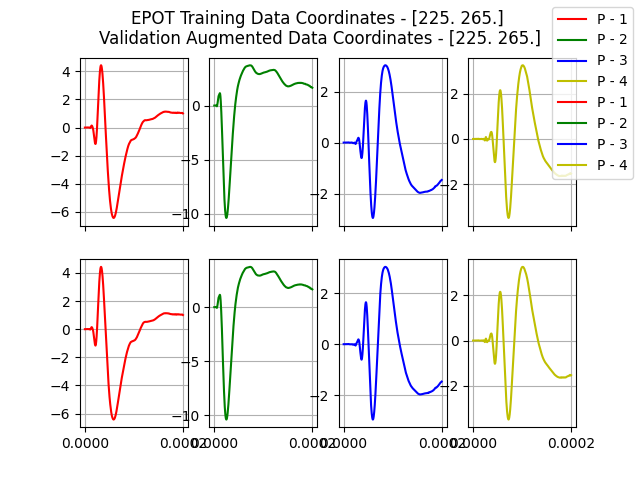

In [23]:
plt.close()
fig, axs = plt.subplots(2, 4, sharex=True)

val_c = 1 # Given validation folder has 4 data points. so use - (0, 1, 2, 3)

# find out the index of the validation set in the training data
x = []
for i in range (0, len(training_labels)):
    if (training_labels[i][0] == validation_aug_labels[val_c][0]) and (training_labels[i][1] == validation_aug_labels[val_c][1]):
        x.append(i)

# plot to compare the validation set with the training set
fig.suptitle(f'EPOT Training Data Coordinates - {training_labels[x[0]]} \nValidation Augmented Data Coordinates - {validation_aug_labels[val_c]}')

axs[0,0].plot(training[x[0]][:,0], training[x[0]][:,1], label='P - 1', c = 'r')
axs[0,1].plot(training[x[0]][:,0], training[x[0]][:,2], label='P - 2', c = 'g')
axs[0,2].plot(training[x[0]][:,0], training[x[0]][:,3], label='P - 3', c = 'b')
axs[0,3].plot(training[x[0]][:,0], training[x[0]][:,4], label='P - 4', c = 'y')

axs[1,0].plot(validation_aug[val_c][:,0], validation_aug[val_c][:,1], label='P - 1', c = 'r')
axs[1,1].plot(validation_aug[val_c][:,0], validation_aug[val_c][:,2], label='P - 2', c = 'g')
axs[1,2].plot(validation_aug[val_c][:,0], validation_aug[val_c][:,3], label='P - 3', c = 'b')
axs[1,3].plot(validation_aug[val_c][:,0], validation_aug[val_c][:,4], label='P - 4', c = 'y')

# check if the data is exactly the same
for i in range (1, 5):
    if np.all(training[x[0]][:,i] == validation_aug[val_c][:,i], axis = 0):
        print('Data is augmented correctly')

fig.legend()
plt.show()

In [24]:
diff = training[x[0]][:,1] - validation_aug[val_c][:,1]
diff

array([0.     , 0.     , 0.     , ..., 0.00011, 0.00012, 0.00012])

##### -- Check -- for outliers

In [25]:
'''
plt.close()
fig, axs = plt.subplots(2, 2, sharex=True, sharey=True)

for i in range(len(training)):
    axs[0,0].plot(training[i][:,0], training[i][:,1], label='Training P-1')
    axs[0,1].plot(training[i][:,0], training[i][:,2], label='Training P-2')
    axs[1,0].plot(training[i][:,0], training[i][:,3], label='Training P-3')
    axs[1,1].plot(training[i][:,0], training[i][:,4], label='Training P-4')

plt.show()
'''

"\nplt.close()\nfig, axs = plt.subplots(2, 2, sharex=True, sharey=True)\n\nfor i in range(len(training)):\n    axs[0,0].plot(training[i][:,0], training[i][:,1], label='Training P-1')\n    axs[0,1].plot(training[i][:,0], training[i][:,2], label='Training P-2')\n    axs[1,0].plot(training[i][:,0], training[i][:,3], label='Training P-3')\n    axs[1,1].plot(training[i][:,0], training[i][:,4], label='Training P-4')\n\nplt.show()\n"

In [26]:
'''
%matplotlib inline
sns.set(rc={'figure.figsize':(30, 30)})

x = []; y = []; z = []

for i in range(len(training)):
    xi = training_labels[i][0]
    x.append(xi)
    yi = training_labels[i][1]
    y.append(yi)
    zi = pd.DataFrame(training[i][:,1]).max()[0]
    # zi = pd.DataFrame(training[i][:,2]).max()[0]
    # zi = pd.DataFrame(training[i][:,3]).max()[0]
    # zi = pd.DataFrame(training[i][:,4]).max()[0]

    z.append(zi)

df = pd.DataFrame({'x': x, 'y': y, 'z': z})

heatmap1_data = pd.pivot_table(df, values='z', index=['y'], columns='x')

ax = sns.heatmap(heatmap1_data, 
                square=True, 
                annot = True, 
                annot_kws={"fontsize": 10}, 
                fmt='.1f', 
                linewidths=0.1, 
                linecolor='gray',
                cbar_kws = dict(use_gridspec=False, location='right'))

ax.invert_yaxis()
'''

'\n%matplotlib inline\nsns.set(rc={\'figure.figsize\':(30, 30)})\n\nx = []; y = []; z = []\n\nfor i in range(len(training)):\n    xi = training_labels[i][0]\n    x.append(xi)\n    yi = training_labels[i][1]\n    y.append(yi)\n    zi = pd.DataFrame(training[i][:,1]).max()[0]\n    # zi = pd.DataFrame(training[i][:,2]).max()[0]\n    # zi = pd.DataFrame(training[i][:,3]).max()[0]\n    # zi = pd.DataFrame(training[i][:,4]).max()[0]\n\n    z.append(zi)\n\ndf = pd.DataFrame({\'x\': x, \'y\': y, \'z\': z})\n\nheatmap1_data = pd.pivot_table(df, values=\'z\', index=[\'y\'], columns=\'x\')\n\nax = sns.heatmap(heatmap1_data, \n                square=True, \n                annot = True, \n                annot_kws={"fontsize": 10}, \n                fmt=\'.1f\', \n                linewidths=0.1, \n                linecolor=\'gray\',\n                cbar_kws = dict(use_gridspec=False, location=\'right\'))\n\nax.invert_yaxis()\n'

##### Normalize Training Data

In [27]:
# create variables for normalized data
train_norm = np.zeros_like(np.asarray(training)); train_norm_labels = np.zeros_like(np.asarray(training_labels))

for i in range (0, len(training)):
    for j in range (1, 5):
        train_norm[i][:,j] = minmax_scale(training[i][:,j])

scalar = MinMaxScaler()
train_norm_labels = scalar.fit_transform(training_labels)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
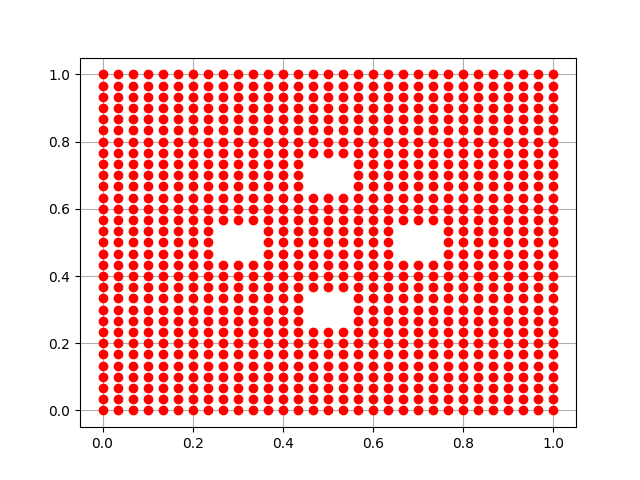

In [28]:
plt.close()
plt.plot(train_norm_labels[:,0], train_norm_labels[:,1], 'o', c = 'r', label = 'Normalized Training Data Labels')
plt.legend(loc='lower center', bbox_to_anchor=(1, -0.5))
plt.show()

##### Resample Training Data

In [29]:
train_resample = []

# create a dataframe from the normalized data
for i in range (0, len(training)):
    train_resample.append(pd.DataFrame(train_norm[i], columns = ['time', '1', '2', '3', '4']))
    # drop the time column
    train_resample[i] = train_resample[i].drop(columns = ['time'])

size = 100

for i in range (0, len(training)):
    train_resample[i] = resample(train_resample[i], size)

np.asarray(train_resample).shape

(925, 100, 4)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
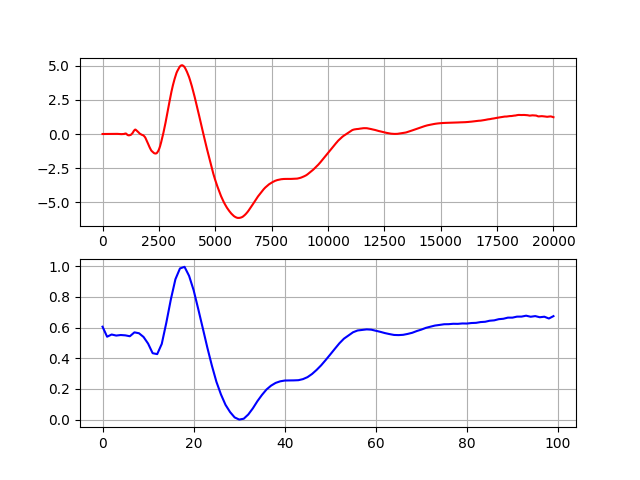

In [30]:
plt.close()
fig, axs = plt.subplots(2, 1)

axs[0].plot(training[0][:,1], c = 'r')
axs[1].plot(train_resample[0][:,1], c = 'b')

plt.show()

#### Export data to pickle

In [31]:
'''
with open('train_resample.pickle', 'wb') as f:
    pickle.dump(train_resample, f)
with open('train_norm_labels.pickle', 'wb') as f:
    pickle.dump(train_norm_labels, f)
'''

"\nwith open('train_resample.pickle', 'wb') as f:\n    pickle.dump(train_resample, f)\nwith open('train_norm_labels.pickle', 'wb') as f:\n    pickle.dump(train_norm_labels, f)\n    "

#### AI Model

##### Split the data into training and testing sets

In [32]:
# Extract the data from the pickle files

'''
with open('train_resample.pickle', 'rb') as f:
    train_resample = pickle.load(f)
with open('train_norm_labels.pickle', 'rb') as f:
    train_norm_labels = pickle.load(f)
'''

X = np.asarray(train_resample)
y = np.asarray(train_norm_labels)

# create split data from the normalized data
size = 0.2
x_train, x_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=size)
print(f'Length of training data - {len(x_train)} length of labels - {len(y_train)} \nLength of test data - {len(x_test)} and length of labels - {len(y_test)}')

Length of training data - 740 length of labels - 740 
Length of test data - 185 and length of labels - 185


##### TensorBoard

In [34]:
%tensorboard --logdir=logs/

UsageError: Line magic function `%tensorboard` not found.


##### Model Training and Tuning

In [35]:
'''
log_files = f'DNN_log.{int(time.time())}'
tuner_logs= f'tunelog/DNN_tuner_log.{int(time.time())}'

tensorboard = TensorBoard(log_dir=f'logs/{log_files}', 
                          histogram_freq=1, 
                          write_graph=True,
                          write_grads=True)


def dnnModel(hp):
    model = Sequential()
    model.add(Flatten(input_shape=(100,4)))
    model.add(Dense(units=hp.Int('layer_1_nodes', 
                    min_value=32, max_value=512, step=32), 
                    activation=hp.Choice("activation_1", ["relu", "sigmoid", "tanh"])))
    
    for i in range(hp.Int('n_layers', min_value=0, max_value=4, step=1)):
        model.add(Dense(units=hp.Int(f'layer_{i+1}_nodes', min_value=32, max_value=512, step=32), activation=hp.Choice(f"activation_{i+1}", ["relu", "sigmoid", "tanh"])))
    
    model.add(Dense(units=2, activation=hp.Choice("activation_out", ['sigmoid', 'linear']))) # output layer

    model.summary()

    # Compile model
    # lr = hp.Float("lr", min_value=1e-4, max_value=1e-2)
    opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
    sgd = tf.keras.optimizers.SGD(learning_rate=0.0001)

    model.compile(loss = hp.Choice('loss', ['mae']),
                optimizer = hp.Choice('optimizer', ['Adam', 'RMSprop']), 
                metrics=['Accuracy'])
    
    return model

# Hyperparameter tuning
tuner = RandomSearch(dnnModel,
                    objective='val_Accuracy',
                    max_trials=50,
                    executions_per_trial=2,
                    directory=tuner_logs,
                    project_name='DNN_tuning')

tuner.search(x=x_train,
            y=y_train,
            epochs=60,
            batch_size=32,
            validation_data=(x_test, y_test),
            callbacks=[tensorboard])
            '''

'\nlog_files = f\'DNN_log.{int(time.time())}\'\ntuner_logs= f\'tunelog/DNN_tuner_log.{int(time.time())}\'\n\ntensorboard = TensorBoard(log_dir=f\'logs/{log_files}\', \n                          histogram_freq=1, \n                          write_graph=True,\n                          write_grads=True)\n\n\ndef dnnModel(hp):\n    model = Sequential()\n    model.add(Flatten(input_shape=(100,4)))\n    model.add(Dense(units=hp.Int(\'layer_1_nodes\', \n                    min_value=32, max_value=512, step=32), \n                    activation=hp.Choice("activation_1", ["relu", "sigmoid", "tanh"])))\n    \n    for i in range(hp.Int(\'n_layers\', min_value=0, max_value=4, step=1)):\n        model.add(Dense(units=hp.Int(f\'layer_{i+1}_nodes\', min_value=32, max_value=512, step=32), activation=hp.Choice(f"activation_{i+1}", ["relu", "sigmoid", "tanh"])))\n    \n    model.add(Dense(units=2, activation=hp.Choice("activation_out", [\'sigmoid\', \'linear\']))) # output layer\n\n    model.summary()\

In [36]:
# bestModels = tuner.get_best_models(num_models=2)

In [37]:
# Save the keras model
# model.save(f'model/complete_tunedModel_95perAcc.{int(time.time())}.h5')

#### Model Final

In [59]:
model = Sequential()
model.add(Flatten(input_shape=(100,4)))

model.add(Dense(units=768, activation='relu'))

model.add(Dense(units=352, activation='relu'))

model.add(Dense(units=2, activation='linear'))

model.summary()

# Compile model
opt = tf.keras.optimizers.Adam(lr=0.0001)

model.compile(loss = 'mae', optimizer = opt, metrics=['Accuracy'])

# Fit the model
history = model.fit(x_train, y_train, epochs=50, verbose=1, batch_size=32, validation_data=(x_test, y_test))

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_5 (Flatten)         (None, 400)               0         
                                                                 
 dense_15 (Dense)            (None, 768)               307968    
                                                                 
 dense_16 (Dense)            (None, 352)               270688    
                                                                 
 dense_17 (Dense)            (None, 2)                 706       
                                                                 
Total params: 579,362
Trainable params: 579,362
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50


C:\Users\sreekar\anaconda3\envs\ai\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


24/24 [==============================] - 1s 15ms/step - loss: 0.3004 - Accuracy: 0.5338 - val_loss: 0.2849 - val_Accuracy: 0.5189
Epoch 2/50
24/24 [==============================] - 0s 7ms/step - loss: 0.2440 - Accuracy: 0.6243 - val_loss: 0.2641 - val_Accuracy: 0.5784
Epoch 3/50
24/24 [==============================] - 0s 6ms/step - loss: 0.2135 - Accuracy: 0.6703 - val_loss: 0.2215 - val_Accuracy: 0.6757
Epoch 4/50
24/24 [==============================] - 0s 6ms/step - loss: 0.1853 - Accuracy: 0.7378 - val_loss: 0.1945 - val_Accuracy: 0.7081
Epoch 5/50
24/24 [==============================] - 0s 5ms/step - loss: 0.1528 - Accuracy: 0.8446 - val_loss: 0.1826 - val_Accuracy: 0.8270
Epoch 6/50
24/24 [==============================] - 0s 5ms/step - loss: 0.1360 - Accuracy: 0.8770 - val_loss: 0.1761 - val_Accuracy: 0.7243
Epoch 7/50
24/24 [==============================] - 0s 5ms/step - loss: 0.1261 - Accuracy: 0.8365 - val_loss: 0.1477 - val_Accuracy: 0.7784
Epoch 8/50
24/24 [============

In [60]:
# model.save(f'model/val_acc_94perAcc.{int(time.time())}.h5')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
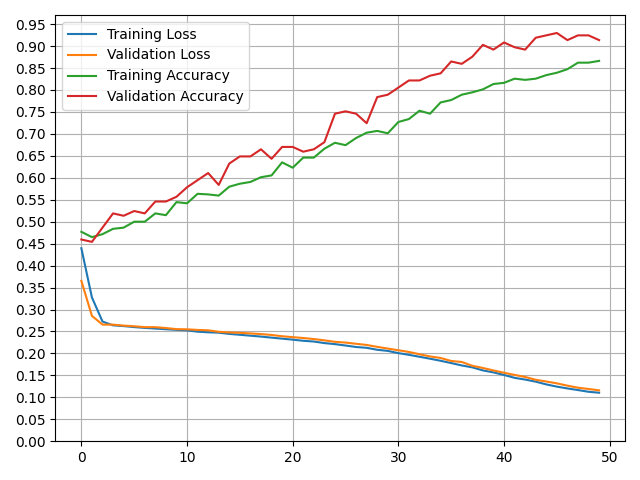

In [40]:
plt.close()
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.plot(history.history['Accuracy'], label='Training Accuracy')
plt.plot(history.history['val_Accuracy'], label='Validation Accuracy')

plt.yticks(np.arange(0, 1, 0.05))

plt.tight_layout()
plt.legend()
plt.show()

#### CNN Model

In [41]:
cnn_model = Sequential()
# create a CNN cnn_model
cnn_model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(100,4)))
cnn_model.add(MaxPooling1D(pool_size=2))
cnn_model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
cnn_model.add(MaxPooling1D(pool_size=2))
cnn_model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
cnn_model.add(MaxPooling1D(pool_size=2))
cnn_model.add(Flatten())
# cnn_model.add(Dense(units=300, activation='linear'))
cnn_model.add(Dense(units=2, activation='linear'))
cnn_model.summary()


# Compile cnn_model
opt = tf.keras.optimizers.Adam(lr=0.0001)

cnn_model.compile(loss = 'mae', optimizer = opt, metrics=['Accuracy'])

# Fit the cnn_model
cnn_history = cnn_model.fit(x_train, y_train, epochs=50, verbose=1, batch_size=32, validation_data=(x_test, y_test))

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_6 (Conv1D)           (None, 98, 32)            416       
                                                                 
 max_pooling1d_6 (MaxPooling  (None, 49, 32)           0         
 1D)                                                             
                                                                 
 conv1d_7 (Conv1D)           (None, 47, 32)            3104      
                                                                 
 max_pooling1d_7 (MaxPooling  (None, 23, 32)           0         
 1D)                                                             
                                                                 
 conv1d_8 (Conv1D)           (None, 21, 32)            3104      
                                                                 
 max_pooling1d_8 (MaxPooling  (None, 10, 32)          

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
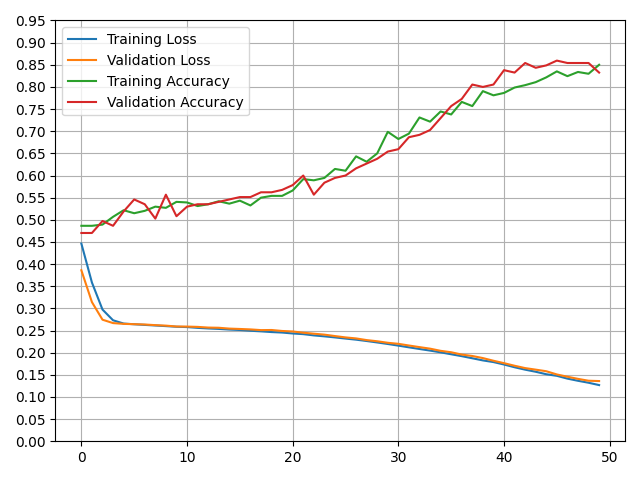

In [43]:
plt.close()
plt.plot(cnn_history.history['loss'], label='Training Loss')
plt.plot(cnn_history.history['val_loss'], label='Validation Loss')
plt.plot(cnn_history.history['Accuracy'], label='Training Accuracy')
plt.plot(cnn_history.history['val_Accuracy'], label='Validation Accuracy')

plt.yticks(np.arange(0, 1, 0.05))

plt.tight_layout()
plt.legend()
plt.show()

#### Predict experimental data validation

In [52]:
# model = tf.keras.models.load_model('model/tunedModel_98perAcc.1640573960.h5')

In [62]:
y_pred = model.predict(np.asarray(ex_val_resample))
y_abs = ex_val_labels
y_pred = scalar.inverse_transform(np.asarray(y_pred))

In [63]:
for i in range(len(y_pred)):
    print(f'Absolute - {y_abs[i]} Predicted - {y_pred[i]} \tDifference - {y_abs[i] - y_pred[i]}')

Absolute - [205. 200.] Predicted - [249.24994 235.20477] 	Difference - [-44.24993896 -35.20477295]
Absolute - [205. 200.] Predicted - [243.38629 233.00531] 	Difference - [-38.3862915  -33.00531006]
Absolute - [205. 200.] Predicted - [263.52042 233.26407] 	Difference - [-58.52041626 -33.2640686 ]
Absolute - [205. 200.] Predicted - [254.35764 234.18161] 	Difference - [-49.3576355  -34.18161011]
Absolute - [225. 210.] Predicted - [235.76537 235.39362] 	Difference - [-10.7653656  -25.39361572]
Absolute - [225. 210.] Predicted - [269.58917 241.44641] 	Difference - [-44.58917236 -31.44641113]
Absolute - [225. 210.] Predicted - [241.36972 220.29066] 	Difference - [-16.36972046 -10.29066467]
Absolute - [225. 210.] Predicted - [240.58112 220.08035] 	Difference - [-15.58111572 -10.08035278]
Absolute - [230. 245.] Predicted - [198.92737 280.17886] 	Difference - [ 31.07263184 -35.17886353]
Absolute - [230. 245.] Predicted - [207.57483 275.96744] 	Difference - [ 22.4251709  -30.96743774]
Absolute -

#### -- Check -- prediction for augmentation validation data

In [64]:
c = []
checking1 = validation_aug[0][:,1:5]
checking1 = minmax_scale(checking1)
checking1 = resample(checking1, 100)

checking2 = validation_aug[1][:,1:5]
checking2 = minmax_scale(checking2)
checking2 = resample(checking2, 100)

checking3 = validation_aug[2][:,1:5]
checking3 = minmax_scale(checking3)
checking3 = resample(checking3, 100)

checking4 = validation_aug[3][:,1:5]
checking4 = minmax_scale(checking4)
checking4 = resample(checking4, 100)

c.append(checking1)
c.append(checking2)
c.append(checking3)
c.append(checking4)

'''
plt.close()
plt.title(f'Validation Data {validation_aug_labels[0]}')
plt.plot(checking1[:,0], label = 'P - 1')
plt.plot(checking1[:,1], label = 'P - 2')
plt.plot(checking1[:,2], label = 'P - 3')
plt.plot(checking1[:,3], label = 'P - 4')
plt.legend()
plt.show()
'''

"\nplt.close()\nplt.title(f'Validation Data {validation_aug_labels[0]}')\nplt.plot(checking1[:,0], label = 'P - 1')\nplt.plot(checking1[:,1], label = 'P - 2')\nplt.plot(checking1[:,2], label = 'P - 3')\nplt.plot(checking1[:,3], label = 'P - 4')\nplt.legend()\nplt.show()\n"

In [65]:
print(f'{validation_aug_labels[0]} \n{validation_aug_labels[1]} \n{validation_aug_labels[2]} \n{validation_aug_labels[3]}')

p = model.predict(np.asarray(c))
p = scalar.inverse_transform(p)
print(p)

error = []
for i in range(0, len(p)):
    a = validation_aug_labels[i][0]-p[i][0]
    b = validation_aug_labels[i][1]-p[i][1]
    e = [a, b]
    error.append(e)

print(f'Difference between the actual and predicted coordinates: \n{np.asarray(error)}')

[225. 235.] 
[225. 265.] 
[275. 235.] 
[275. 265.]
[[222.96017 239.25208]
 [224.1775  265.25592]
 [277.1882  238.89346]
 [273.45166 268.82092]]
Difference between the actual and predicted coordinates: 
[[ 2.03982544 -4.2520752 ]
 [ 0.82249451 -0.25592041]
 [-2.1882019  -3.89346313]
 [ 1.54833984 -3.82092285]]


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
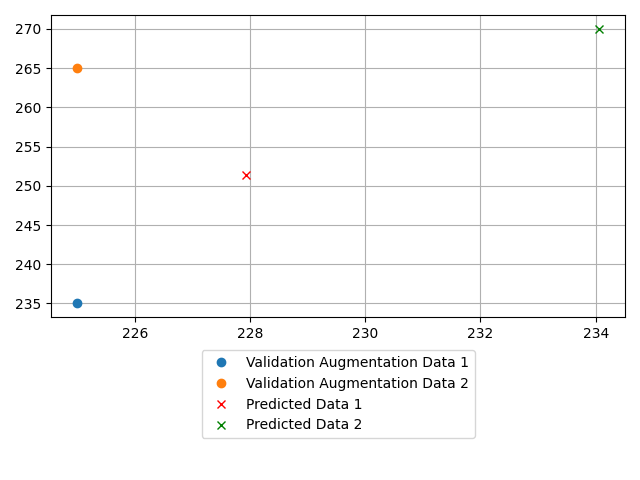

In [57]:
plt.close()
plt.plot(validation_aug_labels[0][0], validation_aug_labels[0][1], 'o' , label = 'Validation Augmentation Data 1')
plt.plot(validation_aug_labels[1][0], validation_aug_labels[1][1], 'o' , label = 'Validation Augmentation Data 2')

plt.plot(p[0][0], p[0][1], 'x' , c = 'r' , label = 'Predicted Data 1')
plt.plot(p[1][0], p[1][1], 'x' , c = 'g' , label = 'Predicted Data 2')

plt.legend(bbox_to_anchor=(0.5,-0.4), loc="lower center", borderaxespad=0)
plt.tight_layout()
plt.show()